In [1]:
from __future__ import absolute_import, division

import os
import urllib, cStringIO

import pymongo as pm

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### setting up paths


In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
features_dir= os.path.join(results_dir,'features')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))

if not os.path.exists(results_dir):
    os.makedirs(results_dir)  

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(features_dir):
    os.makedirs(features_dir)
    
## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))        
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/judithfan/semantic_parts/analysis/analysis_helpers.pyc'>

### helpers

In [3]:
def cleanup_df(X):
    if 'Unnamed: 0' in X.columns:
        X = X.drop(columns=['Unnamed: 0'])
    return X

def flatten(x):
    return [item for sublist in x for item in sublist]

def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

In [4]:
## helper dictionaries 
OBJECT_TO_CATEGORY = {
    'basset': 'dog', 'beetle': 'car', 'bloodhound': 'dog', 'bluejay': 'bird',
    'bluesedan': 'car', 'bluesport': 'car', 'brown': 'car', 'bullmastiff': 'dog',
    'chihuahua': 'dog', 'crow': 'bird', 'cuckoo': 'bird', 'doberman': 'dog',
    'goldenretriever': 'dog', 'hatchback': 'car', 'inlay': 'chair', 'knob': 'chair',
    'leather': 'chair', 'nightingale': 'bird', 'pigeon': 'bird', 'pug': 'dog',
    'redantique': 'car', 'redsport': 'car', 'robin': 'bird', 'sling': 'chair',
    'sparrow': 'bird', 'squat': 'chair', 'straight': 'chair', 'tomtit': 'bird',
    'waiting': 'chair', 'weimaraner': 'dog', 'white': 'car', 'woven': 'chair',
}
CATEGORY_TO_OBJECT = {
    'dog': ['basset', 'bloodhound', 'bullmastiff', 'chihuahua', 'doberman', 'goldenretriever', 'pug', 'weimaraner'],
    'car': ['beetle', 'bluesedan', 'bluesport', 'brown', 'hatchback', 'redantique', 'redsport', 'white'],
    'bird': ['bluejay', 'crow', 'cuckoo', 'nightingale', 'pigeon', 'robin', 'sparrow', 'tomtit'],
    'chair': ['inlay', 'knob', 'leather', 'sling', 'squat', 'straight', 'waiting', 'woven'],
}

### load in data

In [5]:
## loading in files we need
feature_df = cleanup_df(pd.read_csv(os.path.join(features_dir,'semantic_parts_sketch_features_compressed_non-whitened.csv')))
meta_df = cleanup_df(pd.read_csv(os.path.join(features_dir,'semantic_parts_sketch_meta.csv')))

In [6]:
## sanity check: make sure that the numstrokes and arclength features each add up to 1
numstrokes_cols = [i for i in feature_df.columns if i.split('_')[-1]=='numstrokes']
arclength_cols = [i for i in feature_df.columns if i.split('_')[-1]=='arclength']
assert len(np.unique(feature_df[arclength_cols].sum(axis=1).round(10)))==1
assert len(np.unique(feature_df[numstrokes_cols].sum(axis=1).round(10)))==1

In [7]:
## normalize feature_df (apply whitening)? 
## Warning, this will make it so numstrokes and arclength features DO NOT add up to 1
whitening = False
if whitening:
    feature_df = normalize(feature_df)
    print 'Applied whitening to raw feature matrix.'
else:
    print 'Did not apply whitening to raw feature matrix.'

Did not apply whitening to raw feature matrix.


In [8]:
## concatenate meta and features to enable easy subsetting of dataframe
F = pd.concat((meta_df,feature_df),axis=1)

### aggregate by (object, context-condition)

In [9]:
## aggregate by target and condition and take the mean across rows within each group
F2 = F.groupby(['target','condition']).mean().reset_index()

In [10]:
## construct dictionary of object to part labels

## version where each part label within category is treated distinctly
part_dict_expanded = {'bird': ['beak', 'body', 'eye', 'feet', 'head', 'leg', 'tail', 'wing'], \
                     'car': ['body.1', 'bumper', 'door', 'headlight', 'hood', 'trunk', 'wheel', 'window', 'windshield'],\
                     'chair': ['armrest', 'backrest', 'leg.1', 'seat'], \
                     'dog': ['body.2', 'ear', 'eye.1', 'head.1', 'leg.2', 'mouth', 'neck', 'paw', 'tail.1']}

## version where each repeating part labels within category are not distinguished
part_dict_compressed = {'bird': ['beak', 'body', 'eye', 'feet', 'head', 'leg', 'tail', 'wing'], \
                     'car': ['body', 'bumper', 'door', 'headlight', 'hood', 'trunk', 'wheel', 'window', 'windshield'],\
                     'chair': ['armrest', 'backrest', 'leg', 'seat'], \
                     'dog': ['body', 'ear', 'eye', 'head', 'leg', 'mouth', 'neck', 'paw', 'tail']}

## abbreviated handles 
pde = part_dict_expanded
pdc = part_dict_compressed

In [11]:
## re-label the columns feature df that represent numstrokes to contain word 'numstrokes'
part_list = []
for key in pdc.keys():
    part_list.append(pdc[key])
part_list = list(np.unique(flatten(part_list)))

In [12]:
## rename numstroke columns 
for this_part in part_list:
    F2.rename(columns={this_part:'{}_numstrokes'.format(this_part)}, inplace=True)

In [13]:
## add arclength feature to set of columns associated with this category
def add_arclength_cols(part_dict):    
    for category in part_dict.keys():
        part_dict[category] = [i + '_numstrokes' for i in part_dict[category]] + \
                              [i + '_total_arclength' for i in part_dict[category]]
    return part_dict

In [14]:
## now actually add arc length columns to the list of columns considered by the 
pdc = add_arclength_cols(pdc)
pde = add_arclength_cols(pde)

In [15]:
## re-add category back to the F2 dataframe so we can subset on that later
F2['category'] = F2['target'].apply(lambda x: OBJECT_TO_CATEGORY[x])

### subset by context condition and compare

In [16]:
## get names of columns that contain stroke-count & arclength information
numstrokes_cols = [i for i in feature_df.columns if i.split('_')[-1]=='numstrokes']
arclength_cols = [i for i in feature_df.columns if i.split('_')[-1]=='arclength']
feat_cols = numstrokes_cols + arclength_cols

In [39]:
## define scope of comparison
def subset_dataframe_by_condition(F,to_inspect='all',this_category='dog',this_object='pug'):
    '''
    input: F: dataframe (num_sketches x num_features)
           to_inspect: a string indicating whether to subset by ['object','category','all']
           this_category: IF to_inspect == 'category', then we define this to subset by that category only
           this_object: IF to_inspect == 'object', then we define this to subset by that object only
           
    returns: two feature matrices, c and f, corresponding to the close and far subsetted feature matrices
           
    '''
        
    ## get context condition inds for subsetting dataframe
    close_inds = F['condition'] == 'closer'
    far_inds = F['condition'] == 'further'

    ## if we want to inspect particular category
    category_inds = F['category']==this_category

    ## if we want to inspect particular object
    obj_list = np.unique(F.target.values)
    obj_inds = F['target']==this_object  
    
    ## get names of columns that contain stroke-count & arclength information
    numstrokes_cols = [i for i in F.columns if i.split('_')[-1]=='numstrokes']
    arclength_cols = [i for i in F.columns if i.split('_')[-1]=='arclength']
    feat_cols = numstrokes_cols + arclength_cols
    
    if to_inspect == 'object':    
        ## extract particular row corresponding to this OBJECT in each condition
        f = F[(far_inds) & obj_inds][feat_cols].reset_index(drop=True)
        c = F[(close_inds) & obj_inds][feat_cols].reset_index(drop=True)
    elif to_inspect == 'category':
        ## extract particular rows corresponding to this CATEGORY in each condition
        f = F[(category_inds) & (far_inds)][feat_cols].reset_index(drop=True)
        c = F[(category_inds) & (close_inds)][feat_cols].reset_index(drop=True)
    elif to_inspect == 'all':
        ## extract particular rows corresponding to this CATEGORY in each condition
        f = F[far_inds][feat_cols].reset_index(drop=True)
        c = F[close_inds][feat_cols].reset_index(drop=True) 
    return c, f

#### look at distances between average sketch from each (object, context) combination

In [40]:
to_inspect = 'category'
c,f = subset_dataframe_by_condition(F2,to_inspect=to_inspect,this_category='dog')

In [41]:
## stack the close and far feature matrices to get (16 x K) feature matrix
fmat = np.vstack((np.array(c),np.array(f)))

## sanity check to make sure there are a total of 16 rows b/c there are 8 objects x 2 context conditions 
if to_inspect=='category':
    assert np.vstack((np.array(c),np.array(f))).shape[0] == 16
elif to_inspect=='all':
    assert np.vstack((np.array(c),np.array(f))).shape[0] == 64

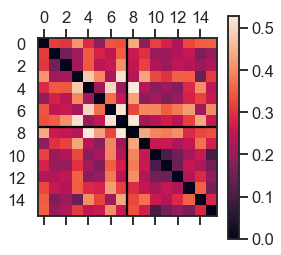

In [42]:
## produce visualization of matrix
from sklearn.metrics import *
sns.set_style('white')
D = pairwise_distances(fmat,metric='euclidean')
plt.matshow(D)
plt.plot((7.5, 7.5), (-0.5, 15.5), 'k-') # vertical refline
plt.plot((-0.5, 15.5), (7.5, 7.5), 'k-') # horizontal refline
plt.colorbar()

#### characterize "context difference vector"

In [43]:
## get difference between close and far
diff = c.sub(f)


#### can we measure relative "spikiness" in close vs. far sketches?
Perhaps using Frobenius norm (root sum squares of each element in the vector),
 which is minimized for uniform vector, and larger for spikier vectors (with larger values concentrated in fewer dimensions)

In [119]:
## helpers
def entropy(probs):    
    return - 1 * sum(map(lambda x: x * np.log(x),probs))

def KL_div_uniform(probs):
    unif_p = 1/len(probs)
    return sum(map(lambda x: unif_p * np.log(unif_p/x),probs))


In [120]:
## extract just the feature columns of the feature matrix, and break out by context 
to_inspect = 'all'
c,f = subset_dataframe_by_condition(F2,to_inspect=to_inspect,this_category='bird')

## renormalize, so that the entire row sums to 1
row_sum = np.unique(c.sum(1).values.round(10))[0]
c = c.div(row_sum)
f = f.div(row_sum)

## convert to numpy array
c = np.array(c)
f = np.array(f)

In [127]:
## get "spikiness" index on close and far average sketches for each object
close_norm = []
far_norm = []
diff_norm = []
for i in np.arange(c.shape[0]):
    close_norm.append(np.linalg.norm(c[i]))
    far_norm.append(np.linalg.norm(c[i]))
    diff_norm.append(np.linalg.norm(c[i])-np.linalg.norm(f[i]))

-0.0353


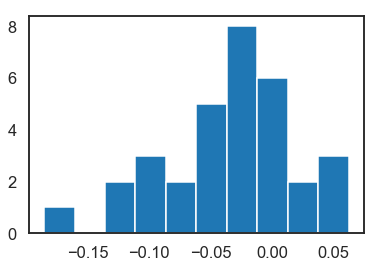

In [131]:
h = plt.hist(diff_norm)
p
print 'Mean close-far difference on spikiness...'.format(np.mean(diff_norm).round(4))

-0.03532066321630559

### relationship between numstrokes and arclength features in unaggregated feature matrix (at sketch level)
I.e., Check how redundant the num strokes vector is with the arclength vector across sketches (how correlated are the 23 vectors across sketches within an object?) 

In [20]:
from scipy.spatial import distance
assert len(np.unique(F[arclength_cols].sum(axis=1).round(10)))==1
assert len(np.unique(F[numstrokes_cols].sum(axis=1).round(10)))==1

In [21]:
## inspect particular category
this_category = 'chair'
category_inds = F['category']==this_category

In [22]:
## extract matrix form of just the arclength and numstrokes columns
to_inspect = 'all'
if to_inspect == 'category':
    arcF = np.array(F[category_inds][arclength_cols])
    numF = np.array(F[category_inds][numstrokes_cols])
elif to_inspect == 'all':
    arcF = np.array(F[arclength_cols])
    numF = np.array(F[numstrokes_cols])    

#### Get a sense for how correspondent the numstrokes and arclength features are (how redundant are they?)

In [23]:
## get distances between sketches using either numstrokes (numF) or arclength (arcF)
feat_type = numF
D = pairwise_distances(feat_type,metric='euclidean')
dists_within_metric = D[np.triu_indices(D.shape[0], k=1)]
print 'Mean euclidean distance between sketches using a single metric (numstrokes or arclength): {}'.format(np.mean(dists_within_metric).round(5))

## get correspondence between numstrokes and arclength feature
dists_btw_metrics = [distance.euclidean(arcV,numV) for(arcV, numV) in zip(arcF,numF)]
print 'Mean euclidean distance within sketches between arclength and numstrokes feature vectors: {}'.format(np.mean(dists_btw_metrics).round(5))

## get distance between randomly sampled numstroke and arclength vector from different sketches
nIter = 1000
num_sketches = np.shape(arcF)[0]
dists_btw_metrics_permuted = []
for this_iter in np.arange(nIter):
    rand_inds = np.random.RandomState(this_iter).choice(num_sketches,2)
    arcV = arcF[rand_inds[0],:]
    numV = numF[rand_inds[1],:]
    dists_btw_metrics_permuted.append(distance.euclidean(arcV,numV))
print "Mean euclidean distance between randomly sampled sketches' arclength and numstrokes feature vectors: {}".format(np.mean(dists_btw_metrics_permuted).round(5)) 

Mean euclidean distance between sketches using a single metric (numstrokes or arclength): 0.67129
Mean euclidean distance within sketches between arclength and numstrokes feature vectors: 0.29786
Mean euclidean distance between randomly sampled sketches' arclength and numstrokes feature vectors: 0.69824


#### Hmm, maybe a better way to do this. How about learning linear mapping from numstrokes to arclength and computing variance explained?

In [24]:
## Assume linear function to map from X to y
## y = Xb
X = arcF 
y = numF

## solve for b directly using pseudo inverse
b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
yhat = X.dot(b)

## get proportion of variance explained
## https://en.wikipedia.org/wiki/Fraction_of_variance_unexplained
## Fraction of variance unexplained, FVU = SS_err / SS_tot
SS_err = np.sum([distance.euclidean(_yhat,_y)**2 for (_yhat, _y) in zip(yhat,y)])
SS_tot = np.sum([distance.euclidean(_y,y.mean(0))**2 for _y in y])
FVU = SS_err / SS_tot
print 'Fraction of variance unexplained after learning linear mapping to arclength to get numstrokes is: {}.'.format(FVU)

Fraction of variance unexplained after learning linear mapping to arclength to get numstrokes is: 0.242202518334.
